# Semi-Supervised Learning: Book Price Prediction

##Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

## Data Exploration

### General

In [ ]:
public_train = pd.read_csv('public-train.csv', sep = '|')
public_test = pd.read_csv('public-test.csv', sep = '|')
public_train_labeled = public_train[public_train.price.isnull()==False]
unlabeled = public_train[public_train.price.isnull()==True]
labeled = pd.concat([public_train_labeled, public_test], axis = 0)
labeled.head(4)

,author_id,description,bookformat,bookedition,pages,published_date,publisher_id,reading_age,lexile_measure,grade_level,...,genre_1_weight,genre_2_weight,genre_3_weight,genre_4_weight,genre_5_weight,genre_6_weight,genre_7_weight,genre_8_weight,genre_9_weight,price
9,author0932,"At long last, New York Times bestselling autho...",Mass Market Paperback,NaN,504.0,"February 28, 2012",publisher149,NaN,NaN,NaN,...,0.21,0.17,0.10,0.08,0.05,0.04,0.04,0.03,0.02,98172.0
17,author2279,I sold my future to the man who ruined my past...,Kindle Edition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57604.0
29,author2386,"From Rob Thomas, the creator of groundbreaking...",Paperback,NaN,324.0,"March 25, 2014",publisher381,NaN,NaN,NaN,...,0.19,0.07,0.07,0.06,0.05,0.04,0.04,0.03,0.02,103658.0
33,author2769,"Hannis Arc, working on the tapestry of lines l...",Hardcover,NaN,528.0,"August 16, 2011",publisher099,NaN,NaN,NaN,...,0.07,0.05,0.02,0.02,0.02,0.02,0.01,0.01,0.01,649665.0


In [ ]:
a = labeled.isnull().sum()/len(labeled)
print("Missing Percentage")
a.sort_values()

Missing Percentage


author_id         0.000000
rating_count_1    0.000000
rating_count_0    0.000000
rating_value_0    0.000000
price             0.000000
bookformat        0.000000
description       0.017258
pages             0.049856
published_date    0.071908
publisher_id      0.071908
genre_0_weight    0.088207
genre_0           0.088207
genre_1_weight    0.105465
genre_1           0.105465
rating_value_1    0.110259
genre_2_weight    0.117929
genre_2           0.117929
genre_3           0.129434
genre_3_weight    0.129434
weight            0.141898
dimension_1       0.143816
dimension_0       0.143816
genre_4_weight    0.144775
genre_4           0.144775
genre_5           0.156280
genre_5_weight    0.156280
genre_6           0.167785
genre_6_weight    0.167785
dimension_2       0.173538
genre_7_weight    0.173538
genre_7           0.173538
genre_8_weight    0.182167
genre_8           0.182167
genre_9           0.191755
genre_9_weight    0.191755
reading_age       0.771812
grade_level       0.817833
l

Variabel **reading_age, grade_level, lexile_measure, bookedition** memiliki missing value lebih dari 70%
<br> -> Drop variabel tersebut

In [ ]:
var = ['reading_age','grade_level','lexile_measure','bookedition']
labeled = labeled.drop(var, axis = 1)

In [ ]:
labeled.iloc[:,:17].head(4)

,author_id,description,bookformat,pages,published_date,publisher_id,weight,rating_value_0,rating_value_1,rating_count_0,rating_count_1,dimension_0,dimension_1,dimension_2,genre_0,genre_1,genre_2
9,author0932,"At long last, New York Times bestselling autho...",Mass Market Paperback,504.0,"February 28, 2012",publisher149,3628.74,4.29,4.6,26983,504,10.72,3.30,16.79,Paranormal Romance,Paranormal,Romance
17,author2279,I sold my future to the man who ruined my past...,Kindle Edition,NaN,NaN,NaN,NaN,4.89,NaN,27,1,NaN,NaN,NaN,NaN,NaN,NaN
29,author2386,"From Rob Thomas, the creator of groundbreaking...",Paperback,324.0,"March 25, 2014",publisher381,3991.61,3.99,4.6,43657,1537,13.31,1.85,20.22,Mystery,Fiction,Audiobook
33,author2769,"Hannis Arc, working on the tapestry of lines l...",Hardcover,528.0,"August 16, 2011",publisher099,771.11,3.68,4.3,19382,1504,16.51,4.32,24.43,Fantasy,Fiction,Epic Fantasy


In [ ]:
labeled.iloc[:,17:].head(4)

,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_0_weight,genre_1_weight,genre_2_weight,genre_3_weight,genre_4_weight,genre_5_weight,genre_6_weight,genre_7_weight,genre_8_weight,genre_9_weight,price
9,Demons,Fantasy,Angels,Mythology,Adult,Urban Fantasy,Supernatural,0.26,0.21,0.17,0.10,0.08,0.05,0.04,0.04,0.03,0.02,98172.0
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57604.0
29,Crime,Contemporary,Mystery Thriller,Adult,Young Adult,Thriller,Adult Fiction,0.45,0.19,0.07,0.07,0.06,0.05,0.04,0.04,0.03,0.02,103658.0
33,High Fantasy,Magic,Adventure,Science Fiction Fantasy,Romance,Adult,Audiobook,0.77,0.07,0.05,0.02,0.02,0.02,0.02,0.01,0.01,0.01,649665.0


In [ ]:
labeled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 9 to 499
Data columns (total 35 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   author_id       1043 non-null   object 
 1   description     1025 non-null   object 
 2   bookformat      1043 non-null   object 
 3   pages           991 non-null    float64
 4   published_date  968 non-null    object 
 5   publisher_id    968 non-null    object 
 6   weight          895 non-null    float64
 7   rating_value_0  1043 non-null   float64
 8   rating_value_1  928 non-null    float64
 9   rating_count_0  1043 non-null   int64  
 10  rating_count_1  1043 non-null   int64  
 11  dimension_0     893 non-null    float64
 12  dimension_1     893 non-null    float64
 13  dimension_2     862 non-null    float64
 14  genre_0         951 non-null    object 
 15  genre_1         933 non-null    object 
 16  genre_2         920 non-null    object 
 17  genre_3         908 non-null    ob

**Variable Type** <br>
**ID:** author_id, publisher_id <br>
**Text:** description <br>
**Date:** published_date <br>
**Categorical:** bookformat & genre <br>
**Numerical:** pages, weight, rating_value, rating_count, dimension, genre_weight, price

### price

In [ ]:
def lihat_numerik(variabel):
    f, ax = plt.subplots(3,1, figsize = (9,7))
    sns.boxplot(labeled[variabel], ax = ax[0])
    sns.distplot(labeled[variabel], ax = ax[1])
    ax[1].axvline(labeled[variabel].mean(), color='r', linestyle='--')
    ax[1].axvline(labeled[variabel].median(), color='tab:orange', linestyle='-')
    ax[1].legend(['Mean','Median'])
    sns.scatterplot(labeled[variabel], labeled['price'], ax = ax[2])
    med = labeled[variabel].median()
    tukey = 1.5*iqr(labeled[variabel])
    outlier = len(labeled[(labeled[variabel] > med + tukey)|(labeled[variabel] < med - tukey)])
    persen_out = outlier/len(labeled)
    missing = labeled[variabel].isnull().sum()
    persen_miss = missing/len(labeled)
    print("Jumlah outlier: {} atau {:.4f}%".format(outlier, persen_out))
    print("Jumlah missing: {} atau {:.4f}%".format(missing, persen_miss))

In [ ]:
q1 = np.percentile(labeled['price'], 25)
q3 = np.percentile(labeled['price'], 75)
print(q3 - q1)
print(iqr(labeled['price']))

169129.5
169129.5


Jumlah outlier: 72 atau 0.0690%
Jumlah missing: 0 atau 0.0000%


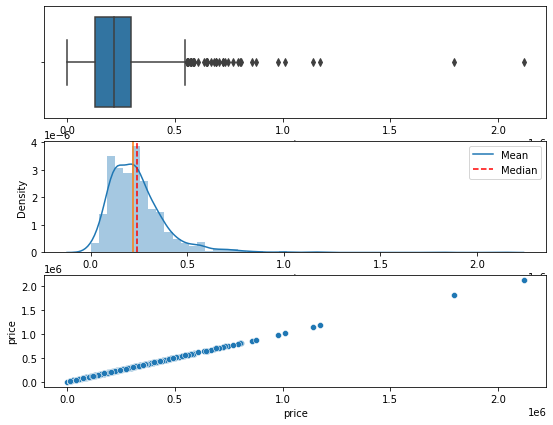

In [ ]:
lihat_numerik('price')

### pages

Jumlah outlier: 0 atau 0.0000%
Jumlah missing: 52 atau 0.0499%


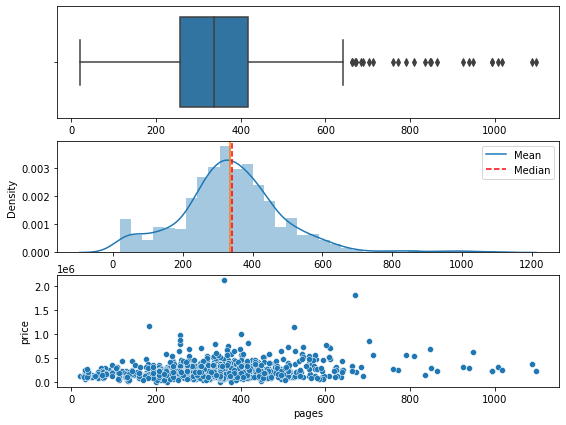

In [ ]:
lihat_numerik('pages')

### weight

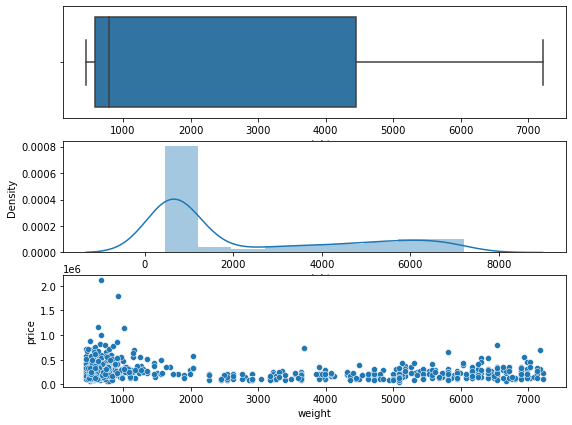

In [ ]:
lihat_numerik('weight')

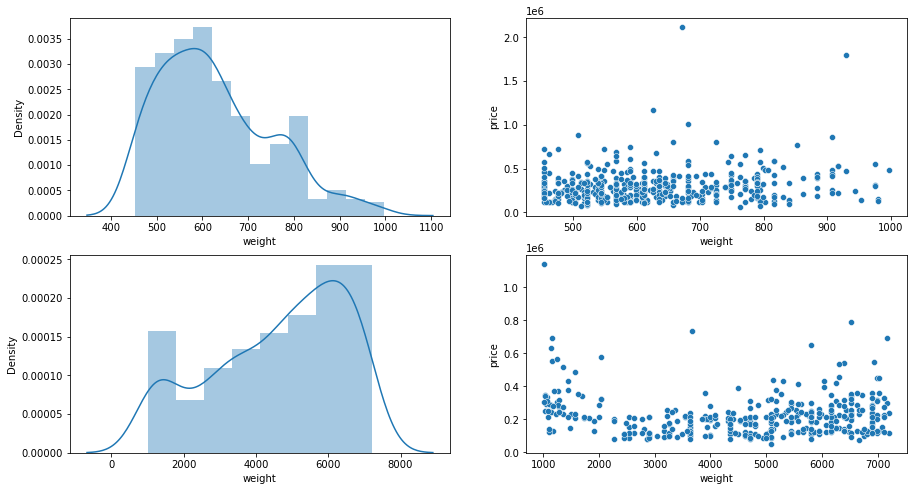

In [ ]:
less = labeled[labeled.weight<= 1000]
over = labeled[labeled.weight > 1000]
f, ax = plt.subplots(2,2, figsize = (15, 8))
sns.distplot(less.weight, ax = ax[0,0])
sns.distplot(over.weight, ax = ax[1,0])
sns.scatterplot(less.weight, less.price, ax = ax[0,1])
sns.scatterplot(over.weight, over.price, ax = ax[1,1])
plt.show()

### rating_value_0

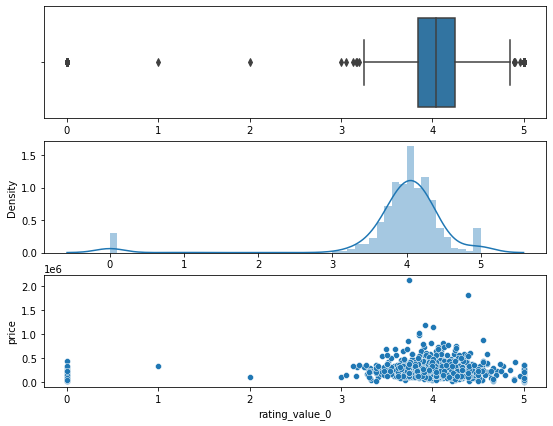

In [ ]:
lihat_numerik('rating_value_0')

### rating_value_1

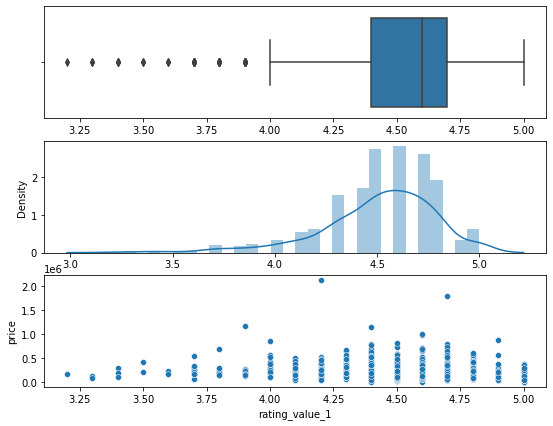

In [ ]:
lihat_numerik('rating_value_1')

### rating_count_0

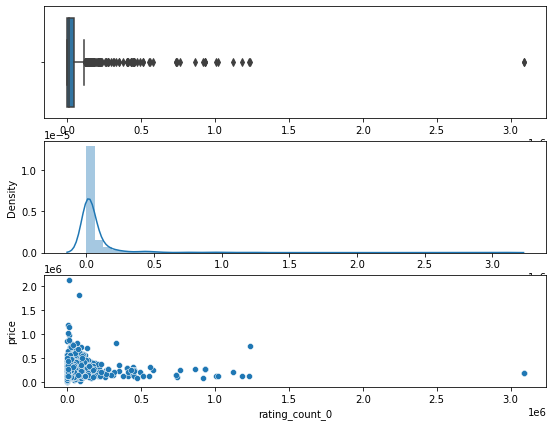

In [ ]:
lihat_numerik('rating_count_0')

### rating_count_1

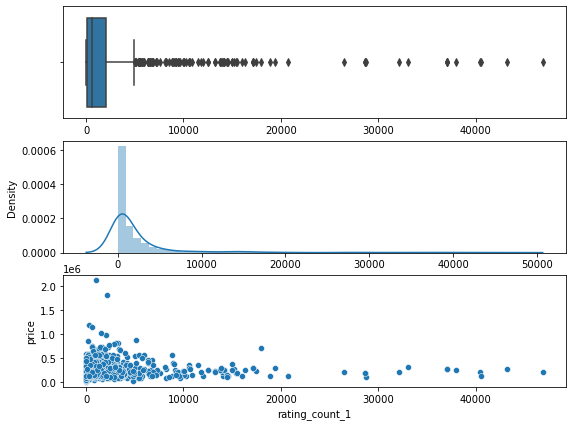

In [ ]:
lihat_numerik('rating_count_1')

### dimension_0

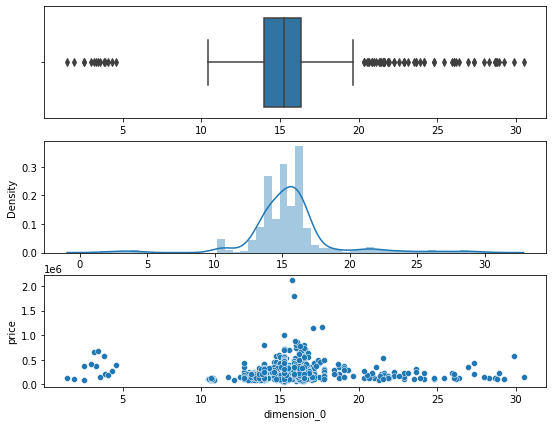

In [ ]:
lihat_numerik('dimension_0')

### dimension_1

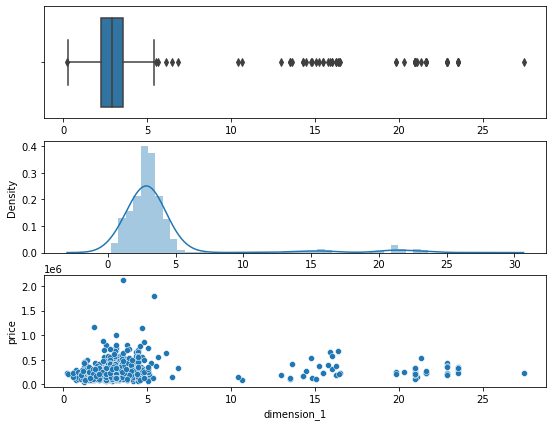

In [ ]:
lihat_numerik('dimension_1')

### dimension_2

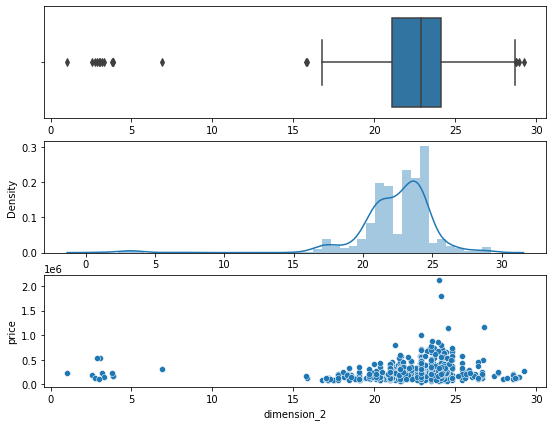

In [ ]:
lihat_numerik('dimension_2')

### genre

In [ ]:
labeled.head(4)

,author_id,description,bookformat,pages,published_date,publisher_id,weight,rating_value_0,rating_value_1,rating_count_0,...,genre_1_weight,genre_2_weight,genre_3_weight,genre_4_weight,genre_5_weight,genre_6_weight,genre_7_weight,genre_8_weight,genre_9_weight,price
9,author0932,"At long last, New York Times bestselling autho...",Mass Market Paperback,504.0,"February 28, 2012",publisher149,3628.74,4.29,4.6,26983,...,0.21,0.17,0.10,0.08,0.05,0.04,0.04,0.03,0.02,98172.0
17,author2279,I sold my future to the man who ruined my past...,Kindle Edition,NaN,NaN,NaN,NaN,4.89,NaN,27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57604.0
29,author2386,"From Rob Thomas, the creator of groundbreaking...",Paperback,324.0,"March 25, 2014",publisher381,3991.61,3.99,4.6,43657,...,0.19,0.07,0.07,0.06,0.05,0.04,0.04,0.03,0.02,103658.0
33,author2769,"Hannis Arc, working on the tapestry of lines l...",Hardcover,528.0,"August 16, 2011",publisher099,771.11,3.68,4.3,19382,...,0.07,0.05,0.02,0.02,0.02,0.02,0.01,0.01,0.01,649665.0


## Data Preprocessing

Data Preprocessing flow:
1. Drop author_id and publisher_id (because these are just id)
2. Just take the word length of description variable
3. Label Encode the bookformat variable
4. Split published_date to month, date, and year
5. Turn the rating_blabla variable into one rating variable: sigma(rating_value(i)*rating_count(i))/sigma(rating_value(i)
6. Multiply all dimensions
7. Turn all genre become one variable: (fiction or nonfiction)
8. Drop all the genre weight because after the tranformation of the genre variable, the weight become unrelevant 

In [ ]:
train = pd.read_csv('public-train.csv', sep = '|')

In [ ]:
train['desc_length'] = train['description'].str.split().str.len()
train[['month', 'date', 'year', 'c']] = train['published_date'].str.split(expand = True)
train['date'] = train['date'].str.rstrip(',')
train['dimension'] = train['dimension_0']*train['dimension_1']*train['dimension_2']
train['rating'] = (train['rating_value_0']*train['rating_count_0'] + train['rating_value_1']*train['rating_count_1'])/(train['rating_count_0']+train['rating_count_1'])

In [ ]:
var = ['genre_0', 'genre_1', 'genre_2','genre_3','genre_4','genre_5','genre_6','genre_7','genre_8', 'genre_9']
train[var] = train[var].fillna("Tidak")
train['genre'] = train[var].agg(' '.join, axis=1)
f = lambda x: -1 if "Tidak" in x else (0 if "Nonfiction" in x else 1)
train['isfiction'] = train['genre'].apply(f)
train['isfiction'][train['isfiction'] == -1] = np.NaN

In [ ]:
train['date'] = pd.to_numeric(train['date'], errors = 'coerce')
train['year'] = pd.to_numeric(train['year'], errors = 'coerce')
month_map = {"january": 1, "february": 2, "march": 3, "april": 4, "may": 5, "june": 6, "july": 7, "august": 8,
            "september": 9, "october": 10, "november": 11, "december": 12}
train['month'] = train['month'].str.lower()
train['bookformat'] = train['bookformat'].str.lower()
train['month'] = train['month'].map(month_map)

In [ ]:
var = ['author_id', 'publisher_id', 'description','c','published_date','rating_value_0','rating_value_1','bookedition',
       'reading_age', 'lexile_measure', 'grade_level', 'rating_count_0', 'rating_count_1', 'dimension_0', 'dimension_1',
       'dimension_2', 'genre','genre_0','genre_1','genre_2','genre_3','genre_4','genre_5','genre_6','genre_7','genre_8',
       'genre_9', 'genre_0_weight', 'genre_1_weight','genre_2_weight','genre_3_weight','genre_4_weight','genre_5_weight',
       'genre_6_weight','genre_7_weight', 'genre_8_weight','genre_9_weight']
train = train.drop(var, axis = 1)

In [ ]:
numerik = ['pages', 'weight', 'desc_length', 'dimension', 'rating']
kategorik = ['bookformat', 'month', 'date', 'year', 'isfiction']
for i in numerik:
    train[i] = train[i].fillna(train[i].mean())
for j in kategorik:
    train[j] = train[j].fillna(train[j].mode().iloc[0])

In [ ]:
a = ["hardcover", "paperback", "kindle edition"]
train['bookformat'] = train['bookformat'].apply(lambda x: x if x in a else "others")
train = pd.get_dummies(train, columns=["bookformat"], prefix=["format"] )
train = train.drop('format_others', axis = 1)

In [ ]:
train

,pages,weight,price,desc_length,month,date,year,dimension,rating,isfiction,format_hardcover,format_kindle edition,format_paperback
0,309.000000,2372.200829,NaN,146.0,5.0,1.0,2012.0,984.726064,4.09234,1.0,1,0,0
1,331.894234,2372.200829,NaN,319.0,5.0,1.0,2012.0,984.726064,4.09234,1.0,0,0,1
2,496.000000,2372.200829,NaN,313.0,5.0,1.0,2012.0,984.726064,4.09234,0.0,1,0,0
3,418.000000,2372.200829,NaN,145.0,5.0,1.0,2012.0,984.726064,4.09234,1.0,1,0,0
4,784.000000,2372.200829,NaN,117.0,5.0,1.0,2012.0,984.726064,4.09234,0.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3545,448.000000,2372.200829,NaN,104.0,5.0,1.0,2012.0,984.726064,4.09234,1.0,0,0,1
3546,478.000000,2372.200829,NaN,126.0,5.0,1.0,2012.0,984.726064,4.09234,1.0,1,0,0
3547,352.000000,2372.200829,NaN,173.0,5.0,1.0,2012.0,984.726064,4.09234,1.0,1,0,0
3548,331.894234,2372.200829,NaN,224.0,5.0,1.0,2012.0,984.726064,4.09234,1.0,0,1,0


In [ ]:
def preprocessing_datatest(dataset):
    dataset['desc_length'] = dataset['description'].str.split().str.len()
    dataset[['month', 'date', 'year']] = dataset['published_date'].str.split(expand = True)
    dataset['date'] = dataset['date'].str.rstrip(',')
    dataset['dimension'] = dataset['dimension_0']*dataset['dimension_1']*dataset['dimension_2']
    dataset['rating'] = (dataset['rating_value_0']*dataset['rating_count_0'] + dataset['rating_value_1']*dataset['rating_count_1'])/(dataset['rating_count_0']+dataset['rating_count_1'])
    var = ['genre_0', 'genre_1', 'genre_2','genre_3','genre_4','genre_5','genre_6','genre_7','genre_8', 'genre_9']
    dataset[var] = dataset[var].fillna("Tidak")
    dataset['genre'] = dataset[var].agg(' '.join, axis=1)
    f = lambda x: -1 if "Tidak" in x else (0 if "Nonfiction" in x else 1)
    dataset['isfiction'] = dataset['genre'].apply(f)
    dataset['isfiction'][dataset['isfiction'] == -1] = np.NaN
    dataset['date'] = pd.to_numeric(dataset['date'], errors = 'coerce')
    dataset['year'] = pd.to_numeric(dataset['year'], errors = 'coerce')
    month_map = {"january": 1, "february": 2, "march": 3, "april": 4, "may": 5, "june": 6, "july": 7, "august": 8,
                 "september": 9, "october": 10, "november": 11, "december": 12}
    dataset['month'] = dataset['month'].str.lower()
    dataset['bookformat'] = dataset['bookformat'].str.lower()
    dataset['month'] = dataset['month'].map(month_map)
    drop = ['author_id', 'publisher_id', 'description','published_date','rating_value_0','rating_value_1','bookedition',
            'reading_age', 'lexile_measure', 'grade_level', 'rating_count_0', 'rating_count_1', 'dimension_0', 'dimension_1',
            'dimension_2', 'genre','genre_0','genre_1','genre_2','genre_3','genre_4','genre_5','genre_6','genre_7','genre_8',
            'genre_9', 'genre_0_weight', 'genre_1_weight','genre_2_weight','genre_3_weight','genre_4_weight','genre_5_weight',
            'genre_6_weight','genre_7_weight', 'genre_8_weight','genre_9_weight']
    dataset = dataset.drop(drop, axis = 1)
    numerik = ['pages', 'weight', 'desc_length', 'dimension', 'rating']
    kategorik = ['bookformat', 'month', 'date', 'year', 'isfiction']
    for i in numerik:
        dataset[i] = dataset[i].fillna(dataset[i].mean())
    for j in kategorik:
        dataset[j] = dataset[j].fillna(dataset[j].mode().iloc[0])
    a = ["hardcover", "paperback", "kindle edition"]
    dataset['bookformat'] = dataset['bookformat'].apply(lambda x: x if x in a else "others")
    dataset = pd.get_dummies(dataset, columns=["bookformat"], prefix=["format"] )
    dataset = dataset.drop('format_others', axis = 1)
    return dataset

In [ ]:
labeled = train[train['price'].isnull() == False]
unlabeled = train[train['price'].isnull() == True]

In [ ]:
labeled

,pages,weight,price,desc_length,month,date,year,dimension,rating,isfiction,format_hardcover,format_kindle edition,format_paperback
9,504.000000,3628.740000,98172.0,136.0,2.0,28.0,2012.0,593.963040,4.295684,1.0,0,0,0
17,331.894234,2372.200829,57604.0,194.0,5.0,1.0,2012.0,984.726064,4.092340,1.0,0,1,0
29,324.000000,3991.610000,103658.0,174.0,3.0,25.0,2014.0,497.887170,4.010745,1.0,0,0,1
33,528.000000,771.110000,649665.0,268.0,8.0,16.0,2011.0,1742.425776,3.724646,1.0,1,0,0
44,500.000000,725.750000,247883.0,332.0,5.0,5.0,2019.0,1104.384888,3.763902,1.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3518,351.000000,512.560000,262176.0,285.0,3.0,19.0,2013.0,1423.025856,3.858323,1.0,1,0,0
3522,257.000000,566.990000,216411.0,165.0,4.0,3.0,2012.0,1029.472146,4.172433,1.0,1,0,0
3529,444.000000,780.180000,152310.0,232.0,7.0,19.0,2011.0,1257.093120,3.856804,0.0,1,0,0
3538,64.000000,3265.860000,176853.0,119.0,6.0,14.0,2011.0,342.827100,4.342671,1.0,1,0,0


In [ ]:
test = pd.read_csv('public-test.csv', sep = '|')

In [ ]:
test = preprocessing_datatest(test)

In [ ]:
x_labeled = labeled.drop('price', axis = 1)
y_labeled = labeled['price']
x_test = test.drop('price', axis = 1)
y_test = test['price']

In [ ]:
scaler = StandardScaler()
x_labeled = scaler.fit_transform(x_labeled)
x_test = scaler.fit_transform(x_test)

In [ ]:
x_labeled

array([[ 1.14751174,  0.63521976, -0.60030771, ..., -1.42009389,
        -0.34914299, -0.47511434],
       [-0.01977313,  0.02664699,  0.10323526, ..., -1.42009389,
         2.86415604, -0.47511434],
       [-0.07331473,  0.81096661, -0.13936577, ..., -1.42009389,
        -0.34914299,  2.10475652],
       ...,
       [ 0.74056958, -0.74440778,  0.5641772 , ...,  0.70417879,
        -0.34914299, -0.47511434],
       [-1.83673075,  0.45946807, -0.80651858, ...,  0.70417879,
        -0.34914299, -0.47511434],
       [-1.75534232, -0.27867645, -0.96420925, ..., -1.42009389,
        -0.34914299,  2.10475652]])

### Linear Regression

In [ ]:
model = LinearRegression()
model.fit(x_labeled, y_labeled)
prediksi_train = model.predict(x_labeled)
prediksi_test = model.predict(x_test)
mse_train = mean_squared_error(y_labeled, prediksi_train)
mse_test = mean_squared_error(y_test, prediksi_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_labeled, prediksi_train)
r2_test = r2_score(y_test, prediksi_test)
print("RMSE Train (labeled): {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))
print("R2 Train (labeled): {}".format(r2_train))
print("R2 Test: {}".format(r2_test))

RMSE Train (labeled): 117531.49097437973
RMSE Test: 171930.49742965412
R2 Train (labeled): 0.27576022539579326
R2 Test: 0.1621802812679044


### kNN

In [ ]:
model = KNeighborsRegressor()
model.fit(x_labeled, y_labeled)
prediksi_train = model.predict(x_labeled)
prediksi_test = model.predict(x_test)
mse_train = mean_squared_error(y_labeled, prediksi_train)
mse_test = mean_squared_error(y_test, prediksi_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_labeled, prediksi_train)
r2_test = r2_score(y_test, prediksi_test)
print("RMSE Train (labeled): {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))
print("R2 Train (labeled): {}".format(r2_train))
print("R2 Test: {}".format(r2_test))

RMSE Train (labeled): 104274.57083613065
RMSE Test: 177925.12381977763
R2 Train (labeled): 0.42992669673714556
R2 Test: 0.1027379661401917


### Decision Tree

In [ ]:
model = DecisionTreeRegressor()
model.fit(x_labeled, y_labeled)
prediksi_train = model.predict(x_labeled)
prediksi_test = model.predict(x_test)
mse_train = mean_squared_error(y_labeled, prediksi_train)
mse_test = mean_squared_error(y_test, prediksi_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_labeled, prediksi_train)
r2_test = r2_score(y_test, prediksi_test)
print("RMSE Train (labeled): {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))
print("R2 Train (labeled): {}".format(r2_train))
print("R2 Test: {}".format(r2_test))

RMSE Train (labeled): 2938.788290439122
RMSE Test: 209805.33272833892
R2 Train (labeled): 0.9995471957623712
R2 Test: -0.24760694482602186


### Random Forest

In [ ]:
model = RandomForestRegressor()
# parameters = {'max_depth': [5,10,20], 'random_state': [123], 'n_estimators': [25, 50, 100, 500, 1000],
#               'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [5, 10, 20, 50], 'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 5, 10], 'min_weight_fraction_leaf': [0.0, 0.2, 0.5]}
# model = GridSearchCV(regressor, parameters, cv = 10)
model.fit(x_labeled, y_labeled)
prediksi_train = model.predict(x_labeled)
prediksi_test = model.predict(x_test)
mse_train = mean_squared_error(y_labeled, prediksi_train)
mse_test = mean_squared_error(y_test, prediksi_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_labeled, prediksi_train)
r2_test = r2_score(y_test, prediksi_test)
# print("Best Parameter: {}".format(model.best_params_))
print("RMSE Train (labeled): {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))
print("R2 Train (labeled): {}".format(r2_train))
print("R2 Test: {}".format(r2_test))

RMSE Train (labeled): 46574.73871433465
RMSE Test: 172806.08412194432
R2 Train (labeled): 0.8862700795241667
R2 Test: 0.15362505970628104


In [ ]:
model.best_params_

{'bootstrap': True,
 'max_features': 'sqrt',
 'n_estimators': 1000,
 'random_state': 123}

### AdaBoost

In [ ]:
model = AdaBoostRegressor()
model.fit(x_labeled, y_labeled)
prediksi_train = model.predict(x_labeled)
prediksi_test = model.predict(x_test)
mse_train = mean_squared_error(y_labeled, prediksi_train)
mse_test = mean_squared_error(y_test, prediksi_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_labeled, prediksi_train)
r2_test = r2_score(y_test, prediksi_test)
print("RMSE Train (labeled): {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))
print("R2 Train (labeled): {}".format(r2_train))
print("R2 Test: {}".format(r2_test))

RMSE Train (labeled): 118199.63147636065
RMSE Test: 179260.81024232905
R2 Train (labeled): 0.2675025348407072
R2 Test: 0.08921588313077666


### Gradient Boosting

In [ ]:
model = GradientBoostingRegressor()
model.fit(x_labeled, y_labeled)
prediksi_train = model.predict(x_labeled)
prediksi_test = model.predict(x_test)
mse_train = mean_squared_error(y_labeled, prediksi_train)
mse_test = mean_squared_error(y_test, prediksi_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_labeled, prediksi_train)
r2_test = r2_score(y_test, prediksi_test)
print("RMSE Train (labeled): {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))
print("R2 Train (labeled): {}".format(r2_train))
print("R2 Test: {}".format(r2_test))

RMSE Train (labeled): 71703.16820823392
RMSE Test: 174741.31018639347
R2 Train (labeled): 0.7304430262786381
R2 Test: 0.13456209342514458


### XGBoost

In [ ]:
model = XGBRegressor()
parameters = {'booster':['dart', 'gbtree'], 'tree_method':['auto'], 'subsample':[0.5,1],'max_depth' : [1,6,10]}
model_xgb = GridSearchCV(model, parameters, cv=10)
model_xgb.fit(x_labeled, y_labeled)
prediksi_train = model_xgb.predict(x_labeled)
prediksi_test = model_xgb.predict(x_test)
mse_train = mean_squared_error(y_labeled, prediksi_train)
mse_test = mean_squared_error(y_test, prediksi_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_labeled, prediksi_train)
r2_test = r2_score(y_test, prediksi_test)
print("Best Parameter: ", model_xgb.best_params_)
print("RMSE Train (labeled): {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))
print("R2 Train (labeled): {}".format(r2_train))
print("R2 Test: {}".format(r2_test))

Best Parameter:  {'booster': 'dart', 'max_depth': 1, 'subsample': 1, 'tree_method': 'auto'}
RMSE Train (labeled): 107864.50608074859
RMSE Test: 170016.5045144046
R2 Train (labeled): 0.3899983644850068
R2 Test: 0.18073027915489848


In [ ]:
model = XGBRegressor(booster = 'gbtree', max_depth = 1, subsample = 1, tree_method = 'auto', random_state = 5,
                     learning_rate = 0.3, min_child_weight = 10, reg_lambda = 0.01)
model.fit(x_labeled, y_labeled)
prediksi_train = model.predict(x_labeled)
prediksi_test = model.predict(x_test)
mse_train = mean_squared_error(y_labeled, prediksi_train)
mse_test = mean_squared_error(y_test, prediksi_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_labeled, prediksi_train)
r2_test = r2_score(y_test, prediksi_test)
print("RMSE Train (labeled): {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))
print("R2 Train (labeled): {}".format(r2_train))
print("R2 Test: {}".format(r2_test))

RMSE Train (labeled): 108429.23081102395
RMSE Test: 169589.6854464178
R2 Train (labeled): 0.3835943156981748
R2 Test: 0.184838598067947


In [ ]:
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV(cv=5,n_alphas=10,l1_ratio=[.1, .5, .7, .9, .95, .99, 1])
model.fit(x_labeled, y_labeled)
prediksi_train = model.predict(x_labeled)
prediksi_test = model.predict(x_test)
mse_train = mean_squared_error(y_labeled, prediksi_train)
mse_test = mean_squared_error(y_test, prediksi_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_labeled, prediksi_train)
r2_test = r2_score(y_test, prediksi_test)
print("RMSE Train (labeled): {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))
print("R2 Train (labeled): {}".format(r2_train))
print("R2 Test: {}".format(r2_test))

RMSE Train (labeled): 117535.87338373541
RMSE Test: 171900.93197549222
R2 Train (labeled): 0.27570621477598867
R2 Test: 0.16246840223620773


In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(iterations=2000)
model.fit(x_labeled, y_labeled)
prediksi_train = model.predict(x_labeled)
prediksi_test = model.predict(x_test)
mse_train = mean_squared_error(y_labeled, prediksi_train)
mse_test = mean_squared_error(y_test, prediksi_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_labeled, prediksi_train)
r2_test = r2_score(y_test, prediksi_test)
print("RMSE Train (labeled): {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))
print("R2 Train (labeled): {}".format(r2_train))
print("R2 Test: {}".format(r2_test))

Learning rate set to 0.020673
0:	learn: 137480.2331558	total: 22.5ms	remaining: 45s
1:	learn: 136847.3252231	total: 28.8ms	remaining: 28.7s
2:	learn: 136189.4266632	total: 34.8ms	remaining: 23.2s
3:	learn: 135534.1585880	total: 39.3ms	remaining: 19.6s
4:	learn: 134886.2454428	total: 42.3ms	remaining: 16.9s
5:	learn: 134280.8761060	total: 44.7ms	remaining: 14.8s
6:	learn: 133594.1108269	total: 46.9ms	remaining: 13.3s
7:	learn: 133017.6597988	total: 48.7ms	remaining: 12.1s
8:	learn: 132425.1852413	total: 50.5ms	remaining: 11.2s
9:	learn: 131888.2566637	total: 52.2ms	remaining: 10.4s
10:	learn: 131396.6174998	total: 53.8ms	remaining: 9.74s
11:	learn: 131072.8118519	total: 54.4ms	remaining: 9.01s
12:	learn: 130610.8226271	total: 55.9ms	remaining: 8.55s
13:	learn: 130135.9914242	total: 57.3ms	remaining: 8.13s
14:	learn: 129669.2671490	total: 58.7ms	remaining: 7.77s
15:	learn: 129189.3299051	total: 60.2ms	remaining: 7.46s
16:	learn: 128727.1273082	total: 61.5ms	remaining: 7.17s
17:	learn: 12

In [ ]:
model = XGBRegressor(booster = 'gbtree', max_depth = 1, subsample = 1, tree_method = 'auto', random_state = 5,
                     learning_rate = 0.3, min_child_weight = 10, reg_lambda = 0.01)
model.fit(x_labeled, y_labeled)
prediksi_train = model.predict(x_labeled)
prediksi_test = model.predict(x_test)
mse_train = mean_squared_error(y_labeled, prediksi_train)
mse_test = mean_squared_error(y_test, prediksi_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_labeled, prediksi_train)
r2_test = r2_score(y_test, prediksi_test)
print("RMSE Train (labeled): {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))
print("R2 Train (labeled): {}".format(r2_train))
print("R2 Test: {}".format(r2_test))

RMSE Train (labeled): 109531.96893340311
RMSE Test: 170785.33035586303
R2 Train (labeled): 0.3709927223877436
R2 Test: 0.1733039424694549


In [ ]:
unlabeled = unlabeled.drop('price', axis = 1)
scaler = StandardScaler()
x_unlabeled = scaler.fit_transform(unlabeled)

In [ ]:
y_unlabeled = model.predict(x_unlabeled)

In [ ]:
x_labeled

array([[ 0.93101625,  1.14751174,  0.63521976, ..., -0.8990561 ,
         0.70711735,  0.51263115],
       [-0.07403708, -0.01977313,  0.02664699, ..., -0.05702804,
         0.03131324,  0.51263115],
       [ 1.93606958, -0.07331473,  0.81096661, ..., -1.1060833 ,
        -0.23986442,  0.51263115],
       ...,
       [-0.57656374,  0.74056958, -0.74440778, ...,  0.52987678,
        -0.7514817 , -1.95072031],
       [-0.57656374, -1.83673075,  0.45946807, ..., -1.44021146,
         0.86327571,  0.51263115],
       [ 1.93606958, -1.75534232, -0.27867645, ..., -1.87051898,
         0.73530867,  0.51263115]])

In [ ]:
x_train = np.concatenate((x_unlabeled, x_labeled), axis = 0)
y_train = np.concatenate((y_unlabeled, y_labeled), axis = 0)

In [ ]:
model = XGBRegressor()
parameters = {'booster':['dart', 'gbtree'], 'tree_method':['auto'], 'subsample':[0.5,1],'max_depth' : [1,6,10]}
model_xgb = GridSearchCV(model, parameters, cv=10)
model_xgb.fit(x_train, y_train)
prediksi_train = model_xgb.predict(x_train)
prediksi_test = model_xgb.predict(x_test)
mse_train = mean_squared_error(y_train, prediksi_train)
mse_test = mean_squared_error(y_test, prediksi_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_train, prediksi_train)
r2_test = r2_score(y_test, prediksi_test)
print("Best Parameter: ", model_xgb.best_params_)
print("RMSE Train: {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))
print("R2 Train: {}".format(r2_train))
print("R2 Test: {}".format(r2_test))

Best Parameter:  {'booster': 'dart', 'max_depth': 1, 'subsample': 1, 'tree_method': 'auto'}
RMSE Train: 43731.317082108384
RMSE Test: 169990.229838286
R2 Train: 0.5555340966710738
R2 Test: 0.18098348261055375


In [ ]:
(booster = 'gbtree', max_depth = 1, subsample = 1, tree_method = 'auto', random_state = 5,
                     learning_rate = 0.3, min_child_weight = 10, reg_lambda = 0.01

In [ ]:
model = XGBRegressor(booster = 'gbtree', max_depth = 1, subsample = 1, tree_method = 'auto',
                     learning_rate = 0.3, min_child_weight = 10, reg_lambda = 10)
model.fit(x_train, y_train)
prediksi_train = model.predict(x_train)
prediksi_test = model.predict(x_test)
mse_train = mean_squared_error(y_train, prediksi_train)
mse_test = mean_squared_error(y_test, prediksi_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_train, prediksi_train)
r2_test = r2_score(y_test, prediksi_test)
# print("Best Parameter: ", model_xgb.best_params_)
print("RMSE Train: {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))
print("R2 Train: {}".format(r2_train))
print("R2 Test: {}".format(r2_test))

RMSE Train: 43861.79620466676
RMSE Test: 169668.1037687207
R2 Train: 0.5528778749402141
R2 Test: 0.18408456201297185


In [ ]:
from lightgbm import LGBMRegressor
model = LGBMRegressor()
model.fit(x_train, y_train)
prediksi_train = model.predict(x_train)
prediksi_test = model.predict(x_test)
mse_train = mean_squared_error(y_train, prediksi_train)
mse_test = mean_squared_error(y_test, prediksi_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_train, prediksi_train)
r2_test = r2_score(y_test, prediksi_test)
print("RMSE Train: {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))
print("R2 Train: {}".format(r2_train))
print("R2 Test: {}".format(r2_test))

RMSE Train: 20643.235333775803
RMSE Test: 174836.22527607047
R2 Train: 0.9009604034683155
R2 Test: 0.1336216698302498


In [ ]:
model = DecisionTreeRegressor()
model.fit(x_train, y_train)
prediksi_train = model.predict(x_train)
prediksi_test = model.predict(x_test)
mse_train = mean_squared_error(y_train, prediksi_train)
mse_test = mean_squared_error(y_test, prediksi_test)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(y_train, prediksi_train)
r2_test = r2_score(y_test, prediksi_test)
print("RMSE Train: {}".format(rmse_train))
print("RMSE Test: {}".format(rmse_test))
print("R2 Train: {}".format(r2_train))
print("R2 Test: {}".format(r2_test))

RMSE Train: 1149.3546018110449
RMSE Test: 202784.05413257738
R2 Train: 0.9996929837142697
R2 Test: -0.1655001694453595


In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units = 128, activation = "relu", input_dim = 10),
    tf.keras.layers.Dense(units = 256, activation = "relu"),
    tf.keras.layers.Dense(units = 1, activation = "linear"),
])
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 34,689
Trainable params: 34,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = "mse", optimizer = "sgd")
model.fit(x_labeled, y_labeled, epochs = 100)

Epoch 1/100
17/17 [==============================] - 0s 2ms/step - loss: nan - root_mean_squared_error: nan                 
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: nan - root_mean_squared_error: nan
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: nan - root_mean_squared_error: nan
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: nan - root_mean_squared_error: nan
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: nan - root_mean_squared_error: nan
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: nan - root_mean_squared_error: nan
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: nan - root_mean_squared_error: nan
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: nan - root_mean_squared_error: nan
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - loss: nan - root_mean_squared_error: nan
Epoch 10/10

In [ ]:
hasil = pd.DataFrame()
hasil['y_pred']=prediksi

In [ ]:
hasil['y_act'] = y_labeled

In [ ]:
hasil['error'] = hasil['y_pred'] - hasil['y_act']

In [ ]:
hasil[(hasil['error']>0) | (hasil['error']<0)]

,y_pred,y_act,error
138,57604.0,86478.0,-28874.0
213,57604.0,100915.0,-43311.0
405,57604.0,14293.0,43311.0
449,57604.0,43167.0,14437.0
818,57604.0,43167.0,14437.0


In [ ]:
sum(hasil['error'])

0.0

In [ ]:
error = np.array(hasil['error'])
error

array([0., 0., 0., ..., 0., 0., 0.])

<AxesSubplot:ylabel='error'>

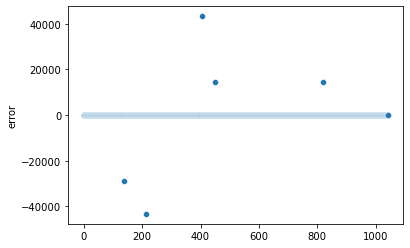

In [ ]:
sns.scatterplot(range(1043),hasil['error'])

In [ ]:
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(labeled, random_state = 123, test_size = 0.2)

In [ ]:
train_set.to_csv('train_set.csv', index = False, sep = ',')
val_set.to_csv('val_set.csv', index = False, sep = ',')